[49, 30, 43, 35, 54, 39]
(256, 128)
(256, 128)
[[  239.-2945.j  -962.-2612.j -1118.-2725.j ... -1374.-3175.j
  -1397.-3227.j  -800.-2563.j]
 [  172.-2756.j -1314.-2952.j -1414.-3182.j ... -1628.-3477.j
  -1665.-3525.j -1168.-2923.j]
 [  292.-2486.j -1697.-3145.j -1675.-3260.j ... -1895.-3688.j
  -1877.-3741.j -1379.-3060.j]
 ...
 [   31. -270.j    86. -212.j    47. -239.j ...    66. -266.j
     83. -275.j    56. -287.j]
 [    7. -206.j    33. -220.j    64. -226.j ...    94. -254.j
     89. -206.j   122. -257.j]
 [   58. -163.j   -25. -194.j    36. -258.j ...    51. -194.j
     67. -227.j    44. -232.j]]
15521.568585594847


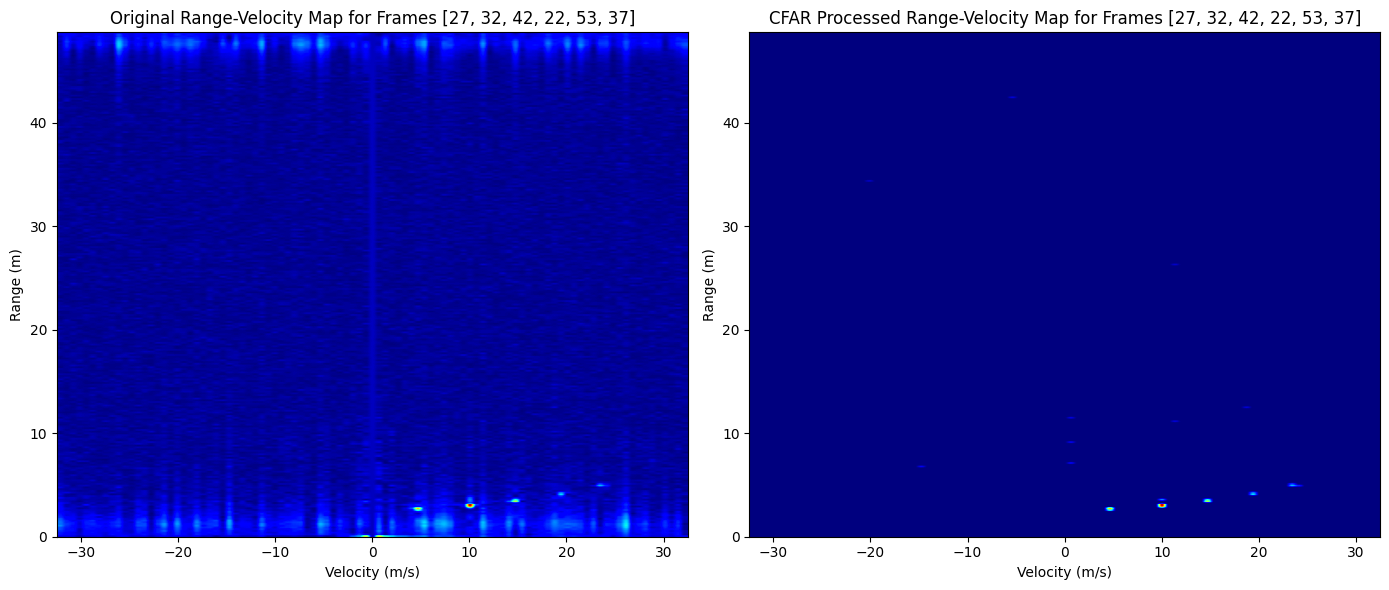

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\FYP-SignalProcessing\\DroneSwarmsImages\\Phantom4_clusters_2\\Range_Velocity_Map_Frame_27_32_42_22_53_37.png'

<Figure size 640x480 with 0 Axes>

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import random
import os
import csv

# Define file path and parameters
# Define CFAR parameters
numTrainingCells = 10
numGuardCells = 2
P_fa = 1e-20  # Desired probability of false alarm
csv_files_created_path= r'D:\Dataset_drone_swarms'
def write_chirps_matrix_to_csv(chirps_matrix, file_path):
    # Open the file in write mode
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write each row of the matrix to the CSV file
        for row in chirps_matrix:
            writer.writerow(row)
def cfar_2d(magnitude_array, numTrainingCells, numGuardCells, P_fa):
    # Get the dimensions of the range-Doppler map
    magnitude_rows, magnitude_cols = magnitude_array.shape
    cfar_output = np.zeros_like(magnitude_array)

    # Loop through the Range-Doppler Map to apply CFAR
    for rangeIdx in range(numTrainingCells + numGuardCells, magnitude_rows - numTrainingCells - numGuardCells):
        for dopplerIdx in range(numTrainingCells + numGuardCells, magnitude_cols - numTrainingCells - numGuardCells):
            # Define the training region (excluding the guard cells)
            training_region = magnitude_array[
                rangeIdx - numTrainingCells - numGuardCells : rangeIdx + numTrainingCells + numGuardCells + 1,
                dopplerIdx - numTrainingCells - numGuardCells : dopplerIdx + numTrainingCells + numGuardCells + 1
            ].copy()

            # Exclude the guard cells by setting them to zero
            training_region[
                numTrainingCells : -numTrainingCells,
                numGuardCells : -numGuardCells
            ] = 0

            # Estimate the noise level from the training region (non-zero values only)
            noise_level = np.mean(training_region[training_region != 0])

            # Calculate the CFAR threshold
            threshold = noise_level * (P_fa ** (-1 / (2 * numTrainingCells * numGuardCells)))
            
            # Compare the cell's value to the threshold
            if magnitude_array[rangeIdx, dopplerIdx] > threshold:
                cfar_output[rangeIdx, dopplerIdx] = magnitude_array[rangeIdx, dopplerIdx]

    return cfar_output

def shifted_data(input_array,range_shift,velocity_shift):
    radar_data=input_array
        # Define parameters
    slope = 29.9817e12
    chirp_duration = 30e-6
    c = 3e8  # Speed of light in m/s
    # Assuming radar_data is already defined as a numpy array
    n_samples = radar_data.shape[1]  # Get number of samples per chirp
    n_chirps = radar_data.shape[0]  # Get number of chirps

    # Calculate the sample rate
    sample_rate = n_samples / chirp_duration

    # Create the time vector for range shift
    time = np.arange(n_samples) / sample_rate
  

    # Calculate the frequency shift due to range shift
    frequency_shift_range = 2 * slope * velocity_shift / c

    # Calculate the phase shift for range shift
    phase_shift_velocity = 2 * np.pi * frequency_shift_range * time

    # Apply the range phase shift to radar data
    shifted_data_array = radar_data * np.exp(-1j * phase_shift_velocity)

    # Define velocity shift
  

    # Create the time vector for velocity shift (column vector)
    time_velocity = np.arange(n_chirps) * chirp_duration

    # Calculate the frequency shift due to velocity shift
    frequency_shift_velocity = 2 * slope * range_shift / c

    # Calculate the phase shift for velocity shift
    phase_shift_range = 2 * np.pi * frequency_shift_velocity * time_velocity

    # Apply the velocity phase shift to the radar data
    shifted_data_array = shifted_data_array * np.exp(-1j * phase_shift_range[:, np.newaxis])  # Broadcasting phase shift across samples
    return shifted_data_array

fileFullPath_1 = r'E:\Radar_Dataset\Ground data UAV + F185\phanton_60_degree(left_side)_same_height_\slave3_0000_data.bin';
fileFullPath_2 = r'E:\Radar_Dataset\Ground data UAV + F185\phanton_60_degree(left_side)_same_height_\slave3_0000_data.bin';
fileFullPath_3 = r'E:\Radar_Dataset\Ground data UAV + F185\phanton_60_degree(left_side)_same_height_\slave3_0000_data.bin';
fileFullPath_4 = r'E:\Radar_Dataset\Ground data UAV + F185\phanton_60_degree(left_side)_same_height_\slave3_0000_data.bin';
fileFullPath_5 = r'E:\Radar_Dataset\Ground data UAV + F185\phanton_60_degree(left_side)_same_height_\slave3_0000_data.bin';
fileFullPath_6 =r'E:\Radar_Dataset\Ground data UAV + F185\phanton_60_degree(left_side)_same_height_\slave3_0000_data.bin';
file_paths=[fileFullPath_1,fileFullPath_2,fileFullPath_3,fileFullPath_4,fileFullPath_5,fileFullPath_6]
frameIdx = 50 # Index of the frame to read
numSamplePerChirp = 256# Number of samples per chirp
numChirpPerLoop = 12  # Number of chirps per loop
numLoops = 128 # Number of loops per frame
numRXPerDevice = 4  # Number of receiving channels per device
numDevices = 4  # Number of devices in the cascade (if needed)
# Create the filter for zero Doppler clutter removal
cutoff_freq =10  # Set cutoff frequency for the high-pass filter (Hz)
sampling_freq = 1000  # Sampling frequency (example value, should match your data)
def butter_highpass(cutoff, fs, order=6):
    """Design a Butterworth high-pass filter."""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a
b, a = butter_highpass(cutoff_freq, sampling_freq)
# Function to read binary radar data
def readBinFile(fileFullPath, frameIdx, numSamplePerChirp, numChirpPerLoop, numLoops, numRXPerDevice):
    Expected_Num_SamplesPerFrame = numSamplePerChirp * numChirpPerLoop * numLoops * numRXPerDevice * 2
    with open(fileFullPath, 'rb') as fp:
        # Move to the desired frame in the file
        fp.seek((frameIdx - 1) * Expected_Num_SamplesPerFrame * 2)
        adcData1 = np.fromfile(fp, dtype=np.uint16, count=Expected_Num_SamplesPerFrame)

    # Convert the 16-bit data to signed integers
    neg = (adcData1 >> 15) == 1  # Check the sign bit
    adcData1 = adcData1.astype(np.int32)
    adcData1[neg] -= 2**16

    # Combine the I and Q channels into complex values
    adcData1 = adcData1[0::2] + 1j * adcData1[1::2]

    # Reshape and permute the data
    adcData1Complex = np.reshape(adcData1, (numRXPerDevice, numSamplePerChirp, numChirpPerLoop, numLoops), order='F')
    adcData1Complex = np.transpose(adcData1Complex, (1, 3, 0, 2))  # Permute dimensions
    return adcData1Complex
# Define the range of possible values
min_value = 15
max_value = 55

# Number of values in the list
num_values = 6

# Function to check if all values in the list have a minimum distance of 3
def has_minimum_distance(values, min_distance=4):
    # Check the distance between each pair of values
    return all(abs(values[i] - values[j]) >= min_distance for i in range(len(values)) for j in range(i + 1, len(values)))

# Generate up to 30 unique valid combinations
valid_combinations = set()


while len(valid_combinations) < 1:
    # Randomly select 4 values within the range
    candidate = random.sample(range(min_value, max_value + 1), num_values)
    
    # Check if the candidate list meets the minimum distance requirement
    if has_minimum_distance(candidate):
        # Convert the list to a tuple to ensure uniqueness in the set
        valid_combinations.add(tuple(candidate))

# Convert each tuple back to a list and print the results
for comb in valid_combinations:
    print(list(comb))
    frame_num_list=list(comb)
    frame_num_list=[27, 32, 42, 22, 53, 37]
    add_both_chirps_matrix = np.zeros((256, 128))

    for i in range(len(frame_num_list)):

        adcDataComplex= readBinFile(file_paths[i], frame_num_list[i], numSamplePerChirp, numChirpPerLoop, numLoops, numRXPerDevice)

        # Select antenna index and extract chirp ADC matrix
        # chirp_ADC_matrix = adcDataComplex[:, :, 3, :]
        # specific_transmitter_data = chirp_ADC_matrix[:, :, 0].T
        # if filter and b is not None and a is not None:
        #     specific_transmitter_data = filtfilt(b,a,specific_transmitter_data , axis=0)
        # chirps_matrix = specific_transmitter_data.T
        # specific_transmitter_data=np.transpose(specific_transmitter_data)
        # add_both_chirps_matrix=add_both_chirps_matrix+specific_transmitter_data
        chirp_ADC_matrix = adcDataComplex[:, :, 3, :]
        specific_transmitter_data = chirp_ADC_matrix[:, :, 0]
      
       
        add_both_chirps_matrix=add_both_chirps_matrix+specific_transmitter_data
    print(add_both_chirps_matrix.shape)    
    fc = 77e9
    c = 3e8
    sweepBandwidth = 0.89e9
    chirpDuration = 30e-6
   
    #add_both_chirps_matrix = filtfilt(b,a,add_both_chirps_matrix , axis=0)
    # if filter and b is not None and a is not None:
    #         add_both_chirps_matrix=np.transpose(add_both_chirps_matrix)
    #         add_both_chirps_matrix = filtfilt(b,a,add_both_chirps_matrix , axis=0)
    #         add_both_chirps_matrix=np.transpose(add_both_chirps_matrix)
    #         chirps_matrix = add_both_chirps_matrix
    
    #mean_value=np.mean(chirps_matrix)
    chirps_matrix = add_both_chirps_matrix
    print(chirps_matrix.shape)  #This matrix is the 2D array of the radar data dimensions are (256,128)
    #please write the code to write  this chirps_matrix in a csv file. i will supply the file path to create a .csv file
    print(chirps_matrix)
    write_chirps_matrix_to_csv(chirps_matrix, os.path.join(csv_files_created_path, f'swarm2_chirps_matrix_of_frames{frame_num_list}.csv'))
    shifted_data_array=shifted_data(chirps_matrix,0,0)
    
    Nfft_range = 290
    Nfft_doppler = 97

    range_fft = np.fft.fft(shifted_data_array, Nfft_range, axis=0)
    doppler_fft = np.fft.fftshift(np.fft.fft(range_fft, Nfft_doppler, axis=1), axes=1)
    


    range_res = c / (2 * sweepBandwidth)
    max_range = range_res * (Nfft_range - 1)
    range_axis = np.linspace(0, max_range, Nfft_range)

    velocity_res = (c / fc) / (2 * numLoops * chirpDuration * 12)
    max_velocity = (c / fc) / (chirpDuration * 4)
    velocity_axis = np.linspace(-max_velocity, max_velocity, Nfft_doppler)
    mean_value=np.mean(np.abs(doppler_fft))
    print( mean_value)
    final_matrix=np.abs(doppler_fft)
    result_remove_zero_bins=final_matrix.copy()
    original_matrix=final_matrix.copy()
    original_matrix[:,48]=mean_value
    final_matrix[:,48]=mean_value
    result_remove_zero_bins[:,48]=mean_value
    final_matrix = filtfilt(b,a,final_matrix , axis=0)
   
    #result_remove_zero_bins=filtfilt(b,a,result_remove_zero_bins , axis=0)
    #result_remove_zero_bins[:,48]=mean_value
    # # Plot the Range-Velocity map (absolute value of FFT)
    cfar_result = cfar_2d(result_remove_zero_bins, numTrainingCells, numGuardCells, P_fa)
   
    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the original Range-Velocity Map
    im1 = ax1.imshow(original_matrix, aspect='auto', extent=[velocity_axis[0], velocity_axis[-1], range_axis[0], range_axis[-1]], 
                    origin='lower', cmap='jet')
    ax1.set_title(f'Original Range-Velocity Map for Frames {frame_num_list}')
    ax1.set_xlabel('Velocity (m/s)')
    ax1.set_ylabel('Range (m)')


    # Plot the CFAR Processed Range-Velocity Map
    im2 = ax2.imshow(cfar_result, aspect='auto', extent=[velocity_axis[0], velocity_axis[-1], range_axis[0], range_axis[-1]], 
                    origin='lower', cmap='jet')
    ax2.set_title(f'CFAR Processed Range-Velocity Map for Frames {frame_num_list}')
    ax2.set_xlabel('Velocity (m/s)')
    ax2.set_ylabel('Range (m)')
  

    # Display the plots
    plt.tight_layout()
    plt.show()
    save_path = r'D:\FYP-SignalProcessing\DroneSwarmsImages\Phantom4_clusters_2'
    # Save the figure
    filename = f"Range_Velocity_Map_Frame_{'_'.join(map(str, frame_num_list))}.png"
    filepath = os.path.join( save_path, filename)
    plt.savefig(filepath)
    plt.close()  # Close the plot to free memory
    print(f"Saved Range-Velocity Map as {filepath}") 



In [2]:
import csv

# Input and output file paths
input_file = r'D:\Dataset_drone_swarms\chirps_matrix.csv'  # Use raw string for Windows paths
output_file = r'D:\Dataset_drone_swarms\cleaned_chirps_matrix.csv'  # Use raw string

# Read the file and process the values
with open(input_file, 'r') as infile, open(output_file, 'w', newline='') as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile)
    
    for row in reader:
        # Clean each cell in the row
        cleaned_row = [cell.strip('()') if cell else '' for cell in row]  # Check for empty cells
        writer.writerow(cleaned_row)

print(f"Cleaned file saved to: {output_file}")



Cleaned file saved to: D:\Dataset_drone_swarms\cleaned_chirps_matrix.csv
